# Statistical NLP - Project

## Context
Classification is probably the most popular task that you would deal with in real life. Text in the form of
blogs, posts, articles, etc. is written every second. It is a challenge to predict the information about the writer
without knowing about him/her. We are going to create a classifier that predicts multiple features of the author
of a given text. We have designed it as a Multi label classification problem.

## Data Description:
Over 600,000 posts from more than 19 thousand bloggers The Blog Authorship Corpus
consists of the collected posts of 19,320 bloggers gathered from blogger.com in August 2004. The corpus
incorporates a total of 681,288 posts and over 140 million words - or approximately 35 posts and 7250 words
per person. Each blog is presented as a separate file, the name of which indicates a blogger id# and the
blogger’s self-provided gender, age, industry, and astrological sign. (All are labelled for gender and age but for
many, industry and/or sign is marked as unknown.) All bloggers included in the corpus fall into one of three age
groups:<br>
- 8240 "10s" blogs (ages 13-17),
- 8086 "20s" blogs(ages 23-27) and
- 2994 "30s" blogs (ages 33-47)<br>

For each age group, there is an equal number of male and female bloggers.
Each blog in the corpus includes at least 200 occurrences of common English words. All formatting has been
stripped with two exceptions. Individual posts within a single blogger are separated by the date of the following
post and links within a post are denoted by the label url link. 

Link to dataset: https://www.kaggle.com/rtatman/blog-authorship-corpus

## Project Objective:
The need is to build a NLP classifier which can use input text parameters to determine the label/s of of the blog.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords, words
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score, precision_score
from textblob import TextBlob, Word
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout, Dense, Embedding, Flatten
import random 
import gensim
from gensim.test.utils import get_tmpfile
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import re
import warnings
warnings.filterwarnings('ignore')

## Load the dataset

In [80]:
dfblogs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/archive.zip')

In [81]:
# Taking 100k data due to machine configuration limitation
dfblogs = dfblogs.sample(100000, random_state=100)

In [82]:
dfblogs.head()

,id,gender,age,topic,sign,date,text
534033,3637628,female,16,Student,Capricorn,"15,June,2004",Mood: Triumphant return Movie o' ...
182201,3343564,female,26,Education,Virgo,"19,July,2004",Up a half pound to 223. Got t...
510474,1404145,male,17,Religion,Cancer,"22,May,2004",Good Morning Bloggers...I agree w...
623995,3510068,female,25,indUnk,Scorpio,"31,May,2004",Last Sunday I completed my fi...
55818,3004257,male,17,Non-Profit,Aquarius,"25,April,2004",This song makes me happy. I haven't pos...


In [83]:
dfblogs.shape

(100000, 7)

<b>Observation:</b>
- There are 100000 rows with 7 attributes.

## Uni and Bi Variate Analysis

In [84]:
dfblogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 534033 to 24722
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      100000 non-null  int64 
 1   gender  100000 non-null  object
 2   age     100000 non-null  int64 
 3   topic   100000 non-null  object
 4   sign    100000 non-null  object
 5   date    100000 non-null  object
 6   text    100000 non-null  object
dtypes: int64(2), object(5)
memory usage: 6.1+ MB


<b>Observation:</b>
- Data type is int64 for id and age attributes.
- Date type is object for rest of the attributes. 
- There is no missing values in dataset.


In [85]:
dfblogs.describe(include='all')

,id,gender,age,topic,sign,date,text
count,1.000000e+05,100000,100000.000000,100000,100000,100000,100000
unique,NaN,2,NaN,40,12,1780,97006
top,NaN,male,NaN,indUnk,Cancer,"02,August,2004",urlLink
freq,NaN,50703,NaN,36873,9602,2394,71
mean,2.401783e+06,NaN,23.921590,NaN,NaN,NaN,NaN
std,1.246019e+06,NaN,7.786012,NaN,NaN,NaN,NaN
min,5.114000e+03,NaN,13.000000,NaN,NaN,NaN,NaN
25%,1.242619e+06,NaN,17.000000,NaN,NaN,NaN,NaN
50%,2.608756e+06,NaN,24.000000,NaN,NaN,NaN,NaN
75%,3.529406e+06,NaN,26.000000,NaN,NaN,NaN,NaN


<b>Observation:</b>
- Most of the bloggers are male
- Blogger''s age range between 13 and 48. Average age is 24. 
- Most of blogs are releated to indUnk
- Sign for many bloggers is Cancer

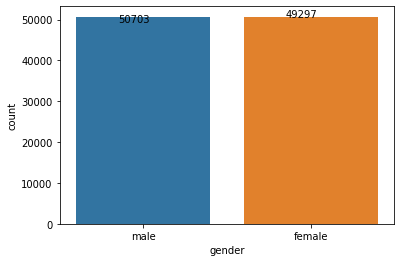

In [86]:
sns.countplot(dfblogs['gender'])
ax = sns.countplot(dfblogs['gender'], 
                   order = dfblogs['gender'].value_counts().index)

for p, label in zip(ax.patches, dfblogs['gender'].value_counts()):
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.25))

**Observation:**
- Almost equal number of male and female bloggers in the dataset.

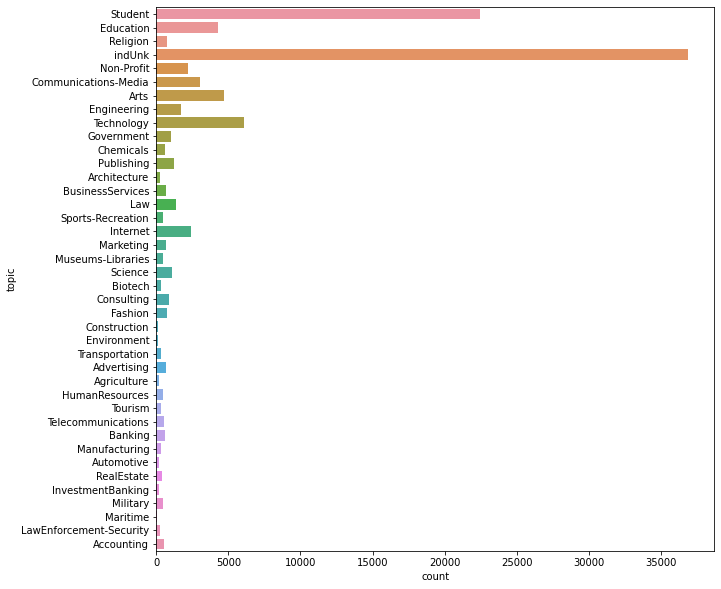

In [87]:
plt.figure(figsize=(10,10))
ax = sns.countplot(y="topic",  data=dfblogs)

**Observation:**
- Many number of bloggers discussed about the topic indUnk then student. 

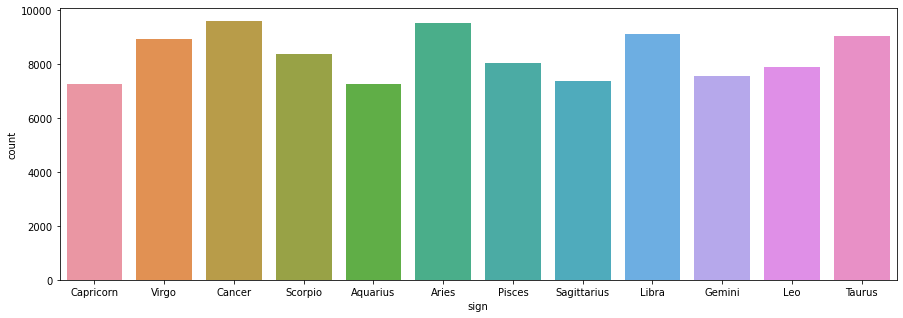

In [88]:
plt.figure(figsize=(15,5))
sns.countplot(dfblogs['sign'])

**Observation:**
- There are high number of Cancer and Aries signs in dataset.

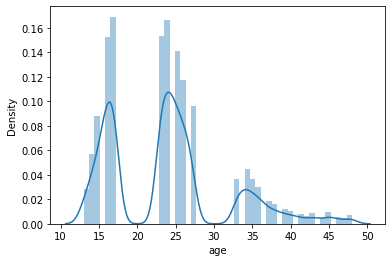

In [89]:
sns.distplot(dfblogs['age'])

In [90]:
np.sort(dfblogs['age'].unique())

array([13, 14, 15, 16, 17, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48])

<b>Observation:</b>
- The bloggers age between 13 and 48

In [91]:
# Bucketizing age
col = 'age'
conditions  = [(dfblogs[col] >=13) & (dfblogs[col] <= 17), (dfblogs[col] >=23) & (dfblogs[col] <= 27),(dfblogs[col] >=33) & (dfblogs[col] <= 49)]
choices     = [ "13-17", "23-27", '33-48']
    
dfblogs["agegroup"] = np.select(conditions, choices, default=np.nan)


In [92]:
dfblogs["agegroup"].value_counts()

23-27    47192
13-17    34666
33-48    18142
Name: agegroup, dtype: int64

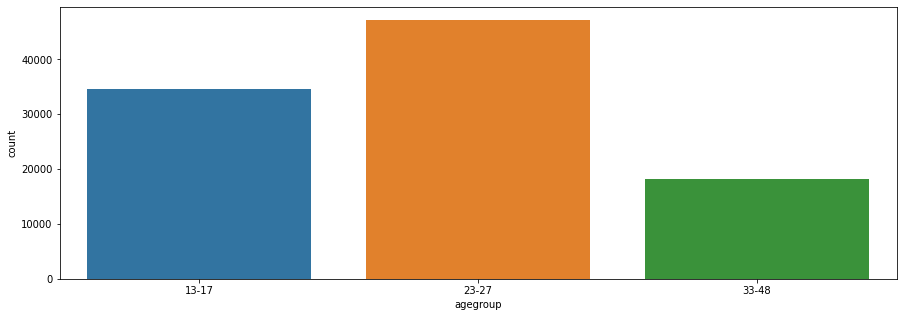

In [93]:
plt.figure(figsize=(15,5))
sns.countplot(dfblogs['agegroup'])

<b>Observation:</b>
- Many bloggers are fall between 23-27 age group. 

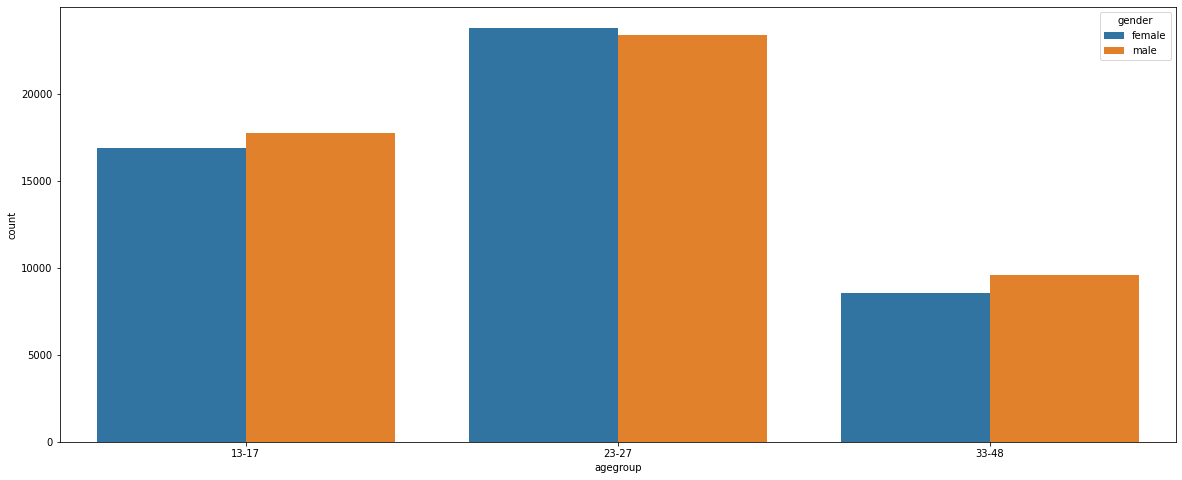

In [94]:
plt.figure(figsize=(20,8))
ax = sns.countplot(x="agegroup", hue="gender", data=dfblogs)

<b>Observation:</b>
- There are almost equal numbers of male and female in all age group.

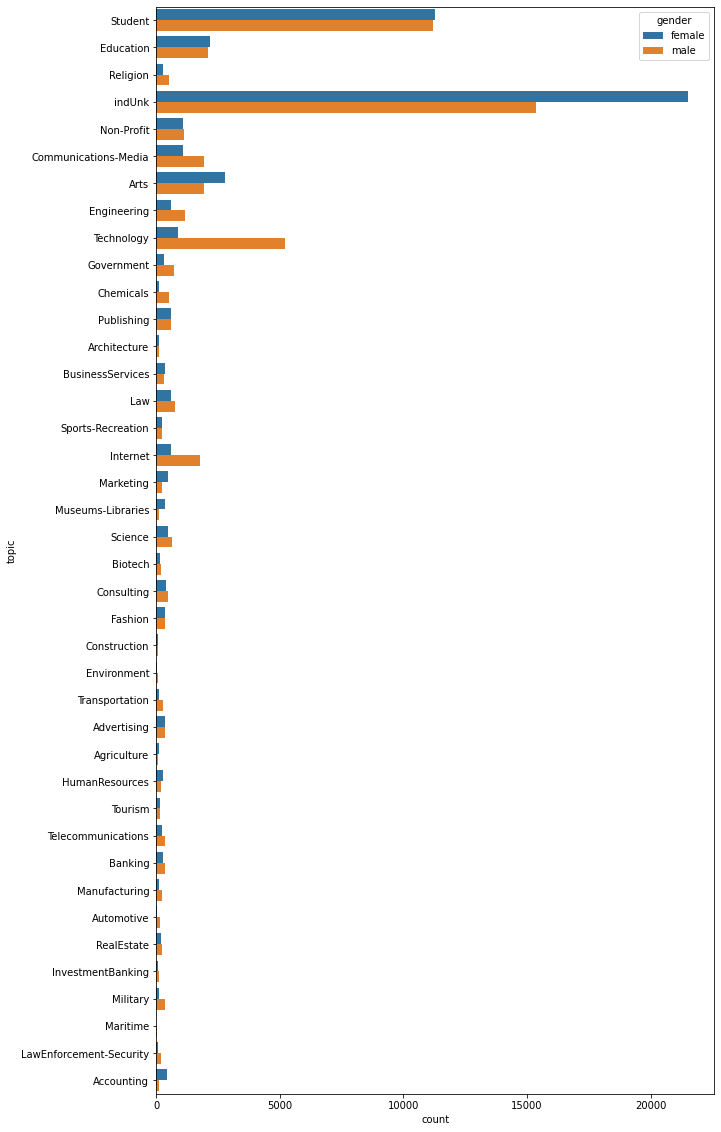

In [95]:
plt.figure(figsize=(10,20))
sns.countplot(y="topic", hue="gender", data=dfblogs)

<b>Observation:</b>
- Many bloggers discussed about topic indUnk

## Preprocessing

### Remove Punctuations

In [96]:
punctuations = string.punctuation

def remove_punctuations(text):
    return text.translate(str.maketrans('','',punctuations))

In [97]:
dfblogs["cleaned_text"] = dfblogs['text'].apply(lambda x: remove_punctuations(x))

In [98]:
dfblogs[["text","cleaned_text"]]

,text,cleaned_text
534033,Mood: Triumphant return Movie o' ...,Mood Triumphant return Movie o th...
182201,Up a half pound to 223. Got t...,Up a half pound to 223 Got to...
510474,Good Morning Bloggers...I agree w...,Good Morning BloggersI agree with...
623995,Last Sunday I completed my fi...,Last Sunday I completed my fi...
55818,This song makes me happy. I haven't pos...,This song makes me happy I havent poste...
...,...,...
232272,I'm already greeting all the Dads out t...,Im already greeting all the Dads out th...
67707,"On another note, I have over 40 digital...",On another note I have over 40 digital ...
573811,Why do they think that people will fall...,Why do they think that people will fall...
462175,The Quaker franchise has accomplished m...,The Quaker franchise has accomplished m...


### Remove Unwanted Spaces

In [99]:
# Replace more than 1 space with 1 space
dfblogs['cleaned_text']= dfblogs['text'].str.replace(r"\s\s+",' ')

# Delete beginning and trailing spaces
dfblogs["cleaned_text"] = dfblogs["cleaned_text"].apply(lambda x: x.strip()) 

In [100]:
dfblogs[["text","cleaned_text"]]

,text,cleaned_text
534033,Mood: Triumphant return Movie o' ...,Mood: Triumphant return Movie o' the week: The...
182201,Up a half pound to 223. Got t...,Up a half pound to 223. Got to stop eating so ...
510474,Good Morning Bloggers...I agree w...,Good Morning Bloggers...I agree with Rob...the...
623995,Last Sunday I completed my fi...,"Last Sunday I completed my first long run, 5 m..."
55818,This song makes me happy. I haven't pos...,This song makes me happy. I haven't posted in ...
...,...,...
232272,I'm already greeting all the Dads out t...,I'm already greeting all the Dads out there......
67707,"On another note, I have over 40 digital...","On another note, I have over 40 digital artwor..."
573811,Why do they think that people will fall...,Why do they think that people will fall for th...
462175,The Quaker franchise has accomplished m...,The Quaker franchise has accomplished many fea...


### Convert to Lower Case

In [101]:
dfblogs["cleaned_text"] = dfblogs["cleaned_text"].str.lower()
dfblogs["topic"] = dfblogs["topic"].str.lower()
dfblogs["sign"] = dfblogs["sign"].str.lower()
dfblogs[["text","cleaned_text"]]

,text,cleaned_text
534033,Mood: Triumphant return Movie o' ...,mood: triumphant return movie o' the week: the...
182201,Up a half pound to 223. Got t...,up a half pound to 223. got to stop eating so ...
510474,Good Morning Bloggers...I agree w...,good morning bloggers...i agree with rob...the...
623995,Last Sunday I completed my fi...,"last sunday i completed my first long run, 5 m..."
55818,This song makes me happy. I haven't pos...,this song makes me happy. i haven't posted in ...
...,...,...
232272,I'm already greeting all the Dads out t...,i'm already greeting all the dads out there......
67707,"On another note, I have over 40 digital...","on another note, i have over 40 digital artwor..."
573811,Why do they think that people will fall...,why do they think that people will fall for th...
462175,The Quaker franchise has accomplished m...,the quaker franchise has accomplished many fea...


### Remove Stopwords

In [102]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [103]:
dfblogs["cleaned_text"] = dfblogs["cleaned_text"].apply(lambda x: remove_stopwords(x)) 

In [104]:
dfblogs[["text","cleaned_text"]]

,text,cleaned_text
534033,Mood: Triumphant return Movie o' ...,mood: triumphant return movie o' week: godfath...
182201,Up a half pound to 223. Got t...,half pound 223. got stop eating much crap. say...
510474,Good Morning Bloggers...I agree w...,good morning bloggers...i agree rob...the life...
623995,Last Sunday I completed my fi...,"last sunday completed first long run, 5 miles...."
55818,This song makes me happy. I haven't pos...,song makes happy. posted long long time. catch...
...,...,...
232272,I'm already greeting all the Dads out t...,i'm already greeting dads there... happy fathe...
67707,"On another note, I have over 40 digital...","another note, 40 digital artworks 50 drawings ..."
573811,Why do they think that people will fall...,think people fall this? people fallen this? --...
462175,The Quaker franchise has accomplished m...,quaker franchise accomplished many feats: cu r...


### Remove Duplicate Characters

In [105]:
def remove_dupcharacters(text):
        return "".join(re.sub("(.)\\1{2,}", "\\1", text))

In [106]:
dfblogs["cleaned_text"] = dfblogs["cleaned_text"].apply(lambda x: remove_dupcharacters(x)) 

In [107]:
dfblogs[["text","cleaned_text"]]

,text,cleaned_text
534033,Mood: Triumphant return Movie o' ...,mood: triumphant return movie o' week: godfath...
182201,Up a half pound to 223. Got t...,half pound 223. got stop eating much crap. say...
510474,Good Morning Bloggers...I agree w...,good morning bloggers.i agree rob.the life ski...
623995,Last Sunday I completed my fi...,"last sunday completed first long run, 5 miles...."
55818,This song makes me happy. I haven't pos...,song makes happy. posted long long time. catch...
...,...,...
232272,I'm already greeting all the Dads out t...,i'm already greeting dads there. happy father'...
67707,"On another note, I have over 40 digital...","another note, 40 digital artworks 50 drawings ..."
573811,Why do they think that people will fall...,think people fall this? people fallen this? - ...
462175,The Quaker franchise has accomplished m...,quaker franchise accomplished many feats: cu r...


### Remove Numbers

In [108]:
def remove_numbers(text):
        return "".join([i for i in text if not i.isdigit()])

In [109]:
dfblogs["cleaned_text"] = dfblogs["cleaned_text"].apply(lambda x: remove_numbers(x)) 

In [110]:
dfblogs[["text","cleaned_text"]]

,text,cleaned_text
534033,Mood: Triumphant return Movie o' ...,mood: triumphant return movie o' week: godfath...
182201,Up a half pound to 223. Got t...,half pound . got stop eating much crap. say ev...
510474,Good Morning Bloggers...I agree w...,good morning bloggers.i agree rob.the life ski...
623995,Last Sunday I completed my fi...,"last sunday completed first long run, miles. ..."
55818,This song makes me happy. I haven't pos...,song makes happy. posted long long time. catch...
...,...,...
232272,I'm already greeting all the Dads out t...,i'm already greeting dads there. happy father'...
67707,"On another note, I have over 40 digital...","another note, digital artworks drawings add ..."
573811,Why do they think that people will fall...,think people fall this? people fallen this? - ...
462175,The Quaker franchise has accomplished m...,quaker franchise accomplished many feats: cu r...


### Remove Non-English words

In [111]:
nltk.download('words')
words = set(nltk.corpus.words.words())

def remove_nonenglish(text):
    return " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [112]:
dfblogs["cleaned_text"] = dfblogs["cleaned_text"].apply(lambda x: remove_nonenglish(x)) 

### Spell Correction

In [113]:
#dfblogs["cleaned_text"] = dfblogs["cleaned_text"].apply(lambda x: TextBlob(x).correct()) 


### Lemmatisation

In [114]:
nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join( lemmatizer.lemmatize(w) for w in text.split())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [115]:
dfblogs["cleaned_text"] = dfblogs["cleaned_text"].apply(lambda x: lemmatize_text(x))

In [116]:
dfblogs[["text","cleaned_text"]]

,text,cleaned_text
534033,Mood: Triumphant return Movie o' ...,mood : triumphant return movie o ' week : godf...
182201,Up a half pound to 223. Got t...,half pound . got stop eating much crap . say ....
510474,Good Morning Bloggers...I agree w...,good morning . i agree rob . the life awesome ...
623995,Last Sunday I completed my fi...,"last first long run , . bad . training regimen..."
55818,This song makes me happy. I haven't pos...,song happy . posted long long time . catch see...
...,...,...
232272,I'm already greeting all the Dads out t...,i ' m already greeting there . happy father ' ...
67707,"On another note, I have over 40 digital...","another note , digital add on , stuff starting..."
573811,Why do they think that people will fall...,think people fall this ? people fallen this ? ...
462175,The Quaker franchise has accomplished m...,quaker franchise accomplished many : record - ...


### Stemming

In [117]:
stemmer = SnowballStemmer('english')

def stem_text(text):
    return " ".join( stemmer.stem(w) for w in text.split())

In [118]:
dfblogs["cleaned_text"] = dfblogs["cleaned_text"].apply(lambda x: stem_text(x))

In [119]:
dfblogs[["text","cleaned_text"]]

,text,cleaned_text
534033,Mood: Triumphant return Movie o' ...,mood : triumphant return movi o ' week : godfa...
182201,Up a half pound to 223. Got t...,half pound . got stop eat much crap . say . ge...
510474,Good Morning Bloggers...I agree w...,good morn . i agre rob . the life awesom event...
623995,Last Sunday I completed my fi...,"last first long run , . bad . train regimen we..."
55818,This song makes me happy. I haven't pos...,song happi . post long long time . catch see ....
...,...,...
232272,I'm already greeting all the Dads out t...,i ' m alreadi greet there . happi father ' s d...
67707,"On another note, I have over 40 digital...","anoth note , digit add on , stuff start get ol..."
573811,Why do they think that people will fall...,think peopl fall this ? peopl fallen this ? - ...
462175,The Quaker franchise has accomplished m...,quaker franchis accomplish mani : record - - ....


### Merge target labels

In [120]:
lbl = dfblogs['gender']+"/"+dfblogs['agegroup']+"/"+dfblogs['topic']+"/"+dfblogs['sign']

dfblogs["labels"] = dfblogs.apply(lambda col :
                            [col["gender"],col["agegroup"],col["topic"],col["sign"]],axis =1)

In [121]:
dfblogs.drop(columns=["id","date","gender","age","agegroup","sign","topic","text"],axis =1, inplace = True)

In [122]:
dfblogs.head(10)

,cleaned_text,labels
534033,mood : triumphant return movi o ' week : godfa...,"[female, 13-17, student, capricorn]"
182201,half pound . got stop eat much crap . say . ge...,"[female, 23-27, education, virgo]"
510474,good morn . i agre rob . the life awesom event...,"[male, 13-17, religion, cancer]"
623995,"last first long run , . bad . train regimen we...","[female, 23-27, indunk, scorpio]"
55818,song happi . post long long time . catch see ....,"[male, 13-17, non-profit, aquarius]"
229884,! auction $! say wow ?!,"[male, 23-27, indunk, cancer]"
187870,yes quarter final tele . but f * ing penalti !...,"[female, 23-27, indunk, aries]"
383076,drive,"[male, 33-48, communications-media, cancer]"
210773,"so , go st joe go see way go see , got stuck t...","[male, 23-27, arts, pisces]"
602749,"know , peopl ask time , ' so how ' s marri lif...","[female, 23-27, education, sagittarius]"


In [123]:
lbl.nunique()

1722

### Split Train and Test Sets

In [124]:
# Set X and y variables
X = dfblogs["cleaned_text"]
y = dfblogs["labels"]

# Split the train and test set
X_train, X_test, y_train, y_test =train_test_split(X,y,  test_size = 0.3, random_state=43)                                      

In [125]:
# Apply the count vectorizer
cvect = CountVectorizer(ngram_range = (1,2), stop_words=stopwords.words('english'), 
                             min_df =2)
X_train_ct = cvect.fit_transform(X_train)
X_test_ct = cvect.transform(X_test)


In [126]:
X_train_ct.shape

(70000, 605287)

In [127]:
X_test_ct.shape

(30000, 605287)

<b>Observation:</b>
- There are 70000 records and 605287 features in training set
- There are 30000 records and 605287 features in test set

In [128]:
# last 50 features
print(cvect.get_feature_names()[-200:])

['zeal', 'zealot', 'zealous', 'zealous go', 'zebra', 'zebra cross', 'zebra cute', 'zebra fantast', 'zebra woman', 'zed', 'zee', 'zel', 'zenith', 'zenith fire', 'zephyr', 'zephyr song', 'zeppelin', 'zeppelin fool', 'zeppelin funni', 'zeppelin immigr', 'zeppelin rock', 'zeppelin song', 'zeppelin stairway', 'zero', 'zero anyway', 'zero chanc', 'zero credibl', 'zero energi', 'zero experi', 'zero get', 'zero go', 'zero graviti', 'zero histori', 'zero hour', 'zero knowledg', 'zero last', 'zero like', 'zero littl', 'zero loss', 'zero mean', 'zero money', 'zero noth', 'zero number', 'zero one', 'zero peopl', 'zero percent', 'zero period', 'zero point', 'zero site', 'zero tenni', 'zero thank', 'zero thing', 'zero time', 'zero toler', 'zero tomorrow', 'zero two', 'zero way', 'zero well', 'zero world', 'zero zero', 'zest', 'zest life', 'zeta', 'zeta look', 'zig', 'zig zag', 'zigzag', 'zimbabw', 'zinc', 'zinfandel', 'zinfandel red', 'zing', 'zip', 'zip along', 'zip bag', 'zip big', 'zip code', 'zi

Create a dictionary to get the count of every label i.e. the key will be label name and value will be the total count of the label.

In [129]:
label_counts=dict()

for labels in dfblogs.labels.values:
  for label in labels:
      if label in label_counts:
          label_counts[str(label)]+=1
      else:
          label_counts[str(label)]=1

label_counts

{'13-17': 34666,
 '23-27': 47192,
 '33-48': 18142,
 'accounting': 557,
 'advertising': 704,
 'agriculture': 181,
 'aquarius': 7278,
 'architecture': 249,
 'aries': 9522,
 'arts': 4726,
 'automotive': 202,
 'banking': 590,
 'biotech': 324,
 'businessservices': 682,
 'cancer': 9602,
 'capricorn': 7265,
 'chemicals': 606,
 'communications-media': 3007,
 'construction': 144,
 'consulting': 866,
 'education': 4266,
 'engineering': 1743,
 'environment': 105,
 'fashion': 732,
 'female': 49297,
 'gemini': 7551,
 'government': 1008,
 'humanresources': 452,
 'indunk': 36873,
 'internet': 2372,
 'investmentbanking': 183,
 'law': 1337,
 'lawenforcement-security': 283,
 'leo': 7893,
 'libra': 9125,
 'male': 50703,
 'manufacturing': 324,
 'maritime': 35,
 'marketing': 684,
 'military': 477,
 'museums-libraries': 457,
 'non-profit': 2207,
 'pisces': 8041,
 'publishing': 1205,
 'realestate': 386,
 'religion': 757,
 'sagittarius': 7366,
 'science': 1078,
 'scorpio': 8383,
 'sports-recreation': 432,
 's

In [130]:
y_train[0]

['male', '13-17', 'student', 'leo']

There are multiple tags in label. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose, it is convenient to use MultiLabelBinarizer from sklearn.

In [131]:
binarizer=MultiLabelBinarizer(classes=sorted(label_counts.keys()))
y_train = binarizer.fit_transform(y_train)
y_test = binarizer.transform(y_test)

In [132]:
y_train[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [133]:
X_train_ct.shape

(70000, 605287)

### Model Building

#### MultinominalNB

In [134]:
# Build the model using MultinominalNB classifier
nb = MultinomialNB(alpha=0.001)
overnb = OneVsRestClassifier(nb)
overnb.fit(X_train_ct, y_train)
y_pred_ovnb = overnb.predict(X_test_ct)

In [135]:
print("Training Accuracy")
print(overnb.score(X_train_ct,y_train))
print("Testing Accuracy")
print(overnb.score(X_test_ct,y_test))

Training Accuracy
0.7416428571428572
Testing Accuracy
0.010966666666666666


In [136]:
print('Accuracy score: ', accuracy_score(y_test, y_pred_ovnb))
print('F1 score: Micro', f1_score(y_test, y_pred_ovnb, average='micro'))
print('Average precision score: Micro', average_precision_score(y_test, y_pred_ovnb, average='micro'))
print('Average recall score: Micro', recall_score(y_test, y_pred_ovnb, average='micro'))

Accuracy score:  0.010966666666666666
F1 score: Micro 0.4036838066001535
Average precision score: Micro 0.22475511062966144
Average recall score: Micro 0.3156


In [138]:
print(classification_report(y_test,y_pred_ovnb))

              precision    recall  f1-score   support

           0       0.71      0.52      0.60     10461
           1       0.60      0.57      0.58     14114
           2       0.47      0.17      0.25      5425
           3       0.06      0.01      0.01       166
           4       0.31      0.02      0.04       209
           5       0.00      0.00      0.00        56
           6       0.18      0.03      0.04      2151
           7       0.00      0.00      0.00        73
           8       0.15      0.02      0.03      2776
           9       0.19      0.03      0.05      1399
          10       0.00      0.00      0.00        65
          11       0.13      0.04      0.06       166
          12       0.00      0.00      0.00        81
          13       0.25      0.02      0.04       208
          14       0.26      0.04      0.07      2943
          15       0.09      0.01      0.02      2187
          16       0.05      0.02      0.03       176
          17       0.07    

<b>Observation:</b>
- There are 57 classess. Training accuracy is 0.74 but overall test accuracy is very poor (0.01)
- <b>Precision:</b>Precision is the ability of a classiifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. Precision scores is 0.77 for class 55 and second highest score is o.71 for class 0. Average precision score is 0.22
- <b>Recall:</b>Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Recall score is 0.67 for class 24. Average recall score is 0.31
- <b>F1 Score:</b>:The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy. Here F1 score is 0.64 for class 24.
- <b>Support:</b>Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.
- <b>Micro Avg:</b> To calculate the micro-F1, we first compute micro-averaged precision and micro-averaged recall over all the samples , and then combine the two. We simply look at all the samples together. Remember that precision is the proportion of True Positives out of the Predicted Positives (TP/(TP+FP)). In the multi-class case, we consider all the correctly predicted samples to be True Positives. Here, F1-micro avg score is 0.40. 

In [139]:
# Define the function to test the prediction for 5 samples
def predicted_value(y_predicted, y_test = y_test , n = 5):
    j = []
    for i in range(n):
        j.append(random.randint(0, len(y_test)))
    print(j)
                 
    for k in j:
        print(binarizer.inverse_transform(y_predicted)[k])
        print(binarizer.inverse_transform(y_test)[k])
        print("=================x==================x================x==========")

In [141]:
predicted_value(y_predicted=y_pred_ovnb,y_test=y_test, n= 5)

[11873, 11513, 19393, 5864, 24389]
('male',)
('33-48', 'gemini', 'male', 'publishing')
=================x==================x================x==========
('23-27', 'indunk', 'male')
('23-27', 'arts', 'female', 'taurus')
=================x==================x================x==========
('33-48', 'indunk', 'male')
('33-48', 'education', 'female', 'leo')
=================x==================x================x==========
('female',)
('23-27', 'capricorn', 'law', 'male')
=================x==================x================x==========
('13-17', 'female', 'student')
('23-27', 'cancer', 'female', 'indunk')
=================x==================x================x==========


<b>Observation:</b>
- First and Fifth Samples: Gender feature prediected correctly and incorrect prediction for rest of the features. 
- Second and Third Samples: Age Group feature predicted correctly and incorrect prediction for resto of the features. 
- Forth Sample: Incorrect prediction for all the features. 
 

#### Logistic Regression

In [142]:
# Build the model using Logistic Regression classifier
lr = LogisticRegression(solver = 'lbfgs',max_iter = 1000, random_state=43)
ovr = OneVsRestClassifier(lr)
ovr.fit(X_train_ct, y_train)
y_pred_lr = ovr.predict(X_test_ct)

In [143]:
print("Training Accuracy")
print(ovr.score(X_train_ct,y_train))
print("Testing Accuracy")
print(ovr.score(X_test_ct,y_test))

Training Accuracy
0.7883142857142857
Testing Accuracy
0.0124


In [144]:
print('Accuracy score: ', accuracy_score(y_test, y_pred_lr))
print('F1 score: Micro', f1_score(y_test, y_pred_lr, average='micro'))
print('Average precision score: Micro', average_precision_score(y_test, y_pred_lr, average='micro'))
print('Average recall score: Micro', recall_score(y_test, y_pred_lr, average='micro'))

Accuracy score:  0.0124
F1 score: Micro 0.4223569403324091
Average precision score: Micro 0.23712883312394342
Average recall score: Micro 0.337025


In [145]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.72      0.58      0.64     10461
           1       0.62      0.58      0.60     14114
           2       0.50      0.24      0.33      5425
           3       0.23      0.03      0.05       166
           4       0.07      0.00      0.01       209
           5       0.00      0.00      0.00        56
           6       0.23      0.04      0.06      2151
           7       0.00      0.00      0.00        73
           8       0.20      0.03      0.06      2776
           9       0.25      0.04      0.07      1399
          10       0.00      0.00      0.00        65
          11       0.04      0.01      0.01       166
          12       0.00      0.00      0.00        81
          13       0.35      0.03      0.06       208
          14       0.30      0.06      0.10      2943
          15       0.15      0.02      0.04      2187
          16       0.04      0.01      0.01       176
          17       0.12    

<b>Observation:</b>
- There are 57 classess. Training accuracy is 0.78 but overall test accuracy is very poor (0.01)
- <b>Precision:</b>Precision is the ability of a classiifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. Precision scores is 0.72 for class 0 and second highest score is o.71 for class 55. Average precision score is 0.23
- <b>Recall:</b>Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Recall score is 0.67 for class 35. Average recall score is 0.33
- <b>F1 Score:</b>:The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy. Here F1 score is 0.65 for class 35.
- <b>Support:</b>Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.
- <b>Micro Avg:</b> To calculate the micro-F1, we first compute micro-averaged precision and micro-averaged recall over all the samples , and then combine the two. We simply look at all the samples together. Remember that precision is the proportion of True Positives out of the Predicted Positives (TP/(TP+FP)). In the multi-class case, we consider all the correctly predicted samples to be True Positives. Here, F1-micro avg score is 0.42. It is bit higher than F1-micro avg score of MultinominalNB model.

In [146]:
predicted_value(y_predicted=y_pred_lr,y_test=y_test, n= 5)

[26359, 25330, 15328, 22159, 25916]
('33-48', 'indunk', 'male')
('33-48', 'indunk', 'male', 'virgo')
=================x==================x================x==========
('male',)
('33-48', 'female', 'indunk', 'sagittarius')
=================x==================x================x==========
('23-27', 'male')
('23-27', 'aries', 'indunk', 'male')
=================x==================x================x==========
('13-17', 'male', 'student')
('13-17', 'cancer', 'male', 'student')
=================x==================x================x==========
('13-17', 'male')
('13-17', 'capricorn', 'female', 'student')
=================x==================x================x==========


<b>Observation:</b>
- First and Fourth Samples: Gender, Age Group and Topic features are prediected correctly and incorrect prediction for Sign feature. 
- Second Sample: Incorrect prediction for all the features. 
- Thrid and Fifth Samples: Gender and Age Group features are prediected correctly and incorrect prediction for  Topic and Sign features.
 
 

#### Decision Tree

In [147]:
# Build the model using Decision Treee Classifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train_ct, y_train)
y_pred_dt = dtc.predict(X_test_ct)

In [148]:
print("Training Accuracy")
print(dtc.score(X_train_ct,y_train))
print("Testing Accuracy")
print(dtc.score(X_test_ct,y_test))

Training Accuracy
0.9393571428571429
Testing Accuracy
0.023566666666666666


In [149]:
print('Accuracy score: ', accuracy_score(y_test, y_pred_dt))
print('F1 score: Micro', f1_score(y_test, y_pred_dt, average='micro'))
print('Average precision score: Micro', average_precision_score(y_test, y_pred_dt, average='micro'))
print('Average recall score: Micro', recall_score(y_test, y_pred_dt, average='micro'))

Accuracy score:  0.023566666666666666
F1 score: Micro 0.33919921462925245
Average precision score: Micro 0.16232540392853334
Average recall score: Micro 0.32824166666666665


In [150]:
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.50      0.49      0.49     10461
           1       0.53      0.52      0.52     14114
           2       0.29      0.23      0.26      5425
           3       0.05      0.04      0.04       166
           4       0.01      0.00      0.01       209
           5       0.00      0.00      0.00        56
           6       0.09      0.08      0.09      2151
           7       0.05      0.05      0.05        73
           8       0.10      0.10      0.10      2776
           9       0.06      0.05      0.05      1399
          10       0.02      0.02      0.02        65
          11       0.00      0.00      0.00       166
          12       0.00      0.00      0.00        81
          13       0.09      0.07      0.08       208
          14       0.13      0.11      0.12      2943
          15       0.09      0.08      0.08      2187
          16       0.01      0.01      0.01       176
          17       0.05    

<b>Observation:</b>
- There are 57 classess. Training accuracy is 0.93 but overall test accuracy is very poor (0.02). It is overfit model.
- <b>Precision:</b>Precision is the ability of a classiifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. Precision scores is 0.56 for class 35 and second highest score is o.55 for class 24. Average precision score is 0.16
- <b>Recall:</b>Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Recall score is 0.55 for class 35. Average recall score is 0.32
- <b>F1 Score:</b>:The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy. Here F1 score is 0.55 for class 35.
- <b>Support:</b>Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.
- <b>Micro Avg:</b> To calculate the micro-F1, we first compute micro-averaged precision and micro-averaged recall over all the samples , and then combine the two. We simply look at all the samples together. Remember that precision is the proportion of True Positives out of the Predicted Positives (TP/(TP+FP)). In the multi-class case, we consider all the correctly predicted samples to be True Positives. Here, F1-micro avg score is 0.33. It is less than F1-micro avg score of MultinominalNB and Logistic Regression model.

In [151]:
predicted_value(y_predicted=y_pred_dt,y_test=y_test, n= 5)

[13839, 11166, 9288, 14379, 13162]
('13-17', 'cancer', 'female', 'student')
('13-17', 'male', 'non-profit', 'scorpio')
=================x==================x================x==========
('23-27', 'male')
('23-27', 'aries', 'female', 'indunk')
=================x==================x================x==========
('23-27', 'aries', 'female', 'student')
('23-27', 'aquarius', 'education', 'female')
=================x==================x================x==========
('13-17', 'female', 'gemini', 'indunk')
('23-27', 'indunk', 'male', 'pisces')
=================x==================x================x==========
('23-27', 'female', 'marketing', 'pisces')
('23-27', 'businessservices', 'cancer', 'male')
=================x==================x================x==========


<b>Observation:</b>
- First, Second and Fifth Samples: Age Group feature prediected correctly and incorrect prediction for rest of the features.  
- Thrid and Fifth Samples: Gender and Age Group features are prediected correctly and incorrect prediction for  Topic and Sign features.
- Fourth Sample: Topic feature prediected correctly and incorrect prediction for rest of the features. 


#### Random Forest

In [152]:
# Build the model using Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(X_train_ct, y_train)
y_pred_rf = rfc.predict(X_test_ct)

In [153]:
print("Training Accuracy")
print(rfc.score(X_train_ct,y_train))
print("Testing Accuracy")
print(rfc.score(X_test_ct,y_test))

Training Accuracy
0.9402714285714285
Testing Accuracy
0.008133333333333333


In [154]:
print('Accuracy score: ', accuracy_score(y_test, y_pred_rf))
print('F1 score: Micro', f1_score(y_test, y_pred_rf, average='micro'))
print('Average precision score: Micro', average_precision_score(y_test, y_pred_rf, average='micro'))
print('Average recall score: Micro', recall_score(y_test, y_pred_rf, average='micro'))

Accuracy score:  0.008133333333333333
F1 score: Micro 0.35911547568488966
Average precision score: Micro 0.20511097149684904
Average recall score: Micro 0.2572


In [155]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.75      0.36      0.49     10461
           1       0.60      0.52      0.56     14114
           2       0.65      0.04      0.08      5425
           3       0.29      0.01      0.02       166
           4       0.00      0.00      0.00       209
           5       0.00      0.00      0.00        56
           6       0.05      0.00      0.00      2151
           7       0.00      0.00      0.00        73
           8       0.24      0.01      0.02      2776
           9       0.21      0.01      0.02      1399
          10       0.00      0.00      0.00        65
          11       0.00      0.00      0.00       166
          12       0.00      0.00      0.00        81
          13       0.67      0.01      0.02       208
          14       0.39      0.02      0.05      2943
          15       0.18      0.01      0.01      2187
          16       0.00      0.00      0.00       176
          17       0.17    

<b>Observation:</b>
- There are 57 classess. Training accuracy is 0.94 but overall test accuracy is very poor (0.008). It is overfit model.
- <b>Precision:</b>Precision is the ability of a classiifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. Precision scores is 0.94 for class 55 and second highest score is 0.75 for class 0. Average precision score is 0.20
- <b>Recall:</b>Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Recall score is 0.64 for class 24. Average recall score is 0.25
- <b>F1 Score:</b>:The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy. Here F1 score is 0.62 for class 24.
- <b>Support:</b>Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.
- <b>Micro Avg:</b> To calculate the micro-F1, we first compute micro-averaged precision and micro-averaged recall over all the samples , and then combine the two. We simply look at all the samples together. Remember that precision is the proportion of True Positives out of the Predicted Positives (TP/(TP+FP)). In the multi-class case, we consider all the correctly predicted samples to be True Positives. Here, F1-micro avg score is 0.35. It is less than F1-micro avg score of MultinominalNB and Logistic Regression model.

In [156]:
predicted_value(y_predicted=y_pred_rf,y_test=y_test, n= 5)

[6050, 29931, 22928, 11318, 9680]
('23-27', 'female')
('23-27', 'environment', 'libra', 'male')
=================x==================x================x==========
('23-27', 'female', 'virgo')
('33-48', 'aries', 'communications-media', 'male')
=================x==================x================x==========
('female',)
('23-27', 'cancer', 'education', 'female')
=================x==================x================x==========
('23-27', 'male')
('23-27', 'communications-media', 'male', 'virgo')
=================x==================x================x==========
('23-27', 'male')
('23-27', 'cancer', 'male', 'manufacturing')
=================x==================x================x==========


<b>Observation:</b>
- First Sample: Age Group feature prediected correctly and incorrect prediction for rest of the features.  
- Second Sample: Prediction is incorrect for all the features.
- Third Sample: Gender feature prediected correctly and incorrect prediction for rest of the features. 
- Fourth and Fifth Samples: Age Group and Gender feature are prediected correctly and incorrect prediction for rest of the features. 

#### Neural Network

In [157]:
# Due to system requirements limitation picking 10k records only
dfblogs_NN = dfblogs.sample(10000)

In [158]:
dfblogs_NN.head()

,cleaned_text,labels
109229,", speak correct speak tire hungri gone bye","[male, 13-17, technology, taurus]"
266776,came back b - day shop ex ( she know yet ) mak...,"[male, 23-27, indunk, aries]"
86100,two understand : . rais religion . . alway par...,"[male, 13-17, technology, aquarius]"
202831,babi cold outsid landlord decid heat system fi...,"[female, 33-48, indunk, aries]"
278928,slight coincident day world sport soccer count...,"[male, 13-17, indunk, virgo]"


In [159]:
# Set the Independent and target variables
X = dfblogs_NN["cleaned_text"]
y = dfblogs_NN["labels"]

# Split the train and test sets
X_train, X_test, y_train, y_test =train_test_split(X,y,  test_size = 0.3, random_state=43)  


In [161]:
#Vocab size
top_words = 10000

t = Tokenizer(num_words=top_words)
t.fit_on_texts(X_train.tolist())

#Get the word index for each of the word in the review
X_train = t.texts_to_sequences(X_train.tolist())
X_test = t.texts_to_sequences(X_test.tolist())

In [162]:
#Each blog size
max_review_length = 300

# Add padding
X_train = sequence.pad_sequences(X_train,maxlen=max_review_length,padding='post')
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length, padding='post')

In [163]:
len(X_train[1])

300

In [164]:
# Word Embedding using Glove
target_file = get_tmpfile('/content/drive/MyDrive/Colab Notebooks/NLP/word2vec.6B.300d.txt')
glove2word2vec('/content/drive/MyDrive/Colab Notebooks/NLP/glove.6B.300d.txt', target_file)

(400000, 300)

In [165]:
word2vec = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Colab Notebooks/NLP/word2vec.6B.300d.txt", binary=False)

In [166]:
#Embedding Length
embedding_vector_length = word2vec.wv.vectors.shape[1]

print('Loaded word2vec model..')
print('Model shape: ', word2vec.wv.vectors.shape)

Loaded word2vec model..
Model shape:  (400000, 300)


In [167]:
word2vec.wv.vectors.shape

(400000, 300)

In [168]:
#Initialize embedding matrix to all zeros
embedding_matrix = np.zeros((top_words + 1, #Vocablury size + 1
                             embedding_vector_length))

#Steps for populating embedding matrix

#1. Check each word in tokenizer vocablury to see if it exist in pre-trained
# word2vec model.
#2. If found, update embedding matrix with embeddings for the word 
# from word2vec model

for word, i in sorted(t.word_index.items(),key=lambda x:x[1]):
    if i > top_words:
        break
    if word in word2vec.wv.vocab:
        embedding_vector = word2vec.wv[word]
        embedding_matrix[i] = embedding_vector

In [169]:
#Check embeddings for word 'great'
embedding_matrix[t.word_index['great']]

array([ 0.23188999, -0.19536   ,  0.033388  , -0.26135001,  0.51484001,
        0.39276001,  0.10469   ,  0.057854  , -0.24567001, -1.56009996,
        0.20387   , -0.26492   , -0.44075999,  0.46224999, -0.15718   ,
        0.20169   , -0.26477   , -0.16019   , -0.38192001,  0.66452998,
       -0.075429  ,  0.30939999,  0.011754  ,  0.0073894 ,  0.10262   ,
       -0.01462   , -0.34276   ,  0.0054704 ,  0.29089999,  0.15917   ,
       -0.025582  ,  0.36114001, -0.94572997,  0.034111  , -1.11389995,
        0.093299  , -0.30590999,  0.38655001,  0.04631   , -0.0087563 ,
        0.035591  , -0.51230001, -0.013579  , -0.14050999,  0.17067   ,
        0.38446999,  0.78362   ,  0.66696   ,  0.066587  , -0.35587001,
        0.38653001, -0.46603   , -0.1972    , -0.20084   , -0.31101   ,
        0.56159002,  0.11281   ,  0.40764001,  0.38773999,  0.23275   ,
        0.54009002, -0.14222001,  0.48638001, -0.098057  , -0.17888001,
       -0.22547001, -0.31621999,  0.40327001, -0.35303   ,  0.03

In [170]:
label_counts=dict()

for labels in dfblogs_NN.labels.values:
  for label in labels:
      if label in label_counts:
          label_counts[str(label)]+=1
      else:
          label_counts[str(label)]=1

In [171]:
binarizer=MultiLabelBinarizer(classes=sorted(label_counts.keys()))

y_train = binarizer.fit_transform(y_train)
y_test = binarizer.transform(y_test)

In [172]:
X_train.shape

(7000, 300)

In [173]:
X_test.shape

(3000, 300)

In [174]:
# To check the number of onehot coded y variable
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [175]:
y_train_cat.shape

(7000, 57, 2)

In [176]:
y_test_cat.shape

(3000, 57, 2)

In [177]:
tf.keras.backend.clear_session()

#Build a sequential model
model = Sequential()

In [178]:
# Add Embedding layer
model.add(Embedding(top_words + 1, #Indexes that we need to deal with                    
                    embedding_vector_length, #embedding_size i.e 300 in this case
                    input_length=max_review_length, #Size of each blof i.e 300 in this case
                    weights=[embedding_matrix], #Pre-trained embedding
                    trainable=True #We do not want to change embedding
                   )
         )

In [179]:

#Flatten embedding layer output and flatten layers
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(400,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(300,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(250,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(57,activation='softmax'))


In [180]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          3000300   
_________________________________________________________________
flatten (Flatten)            (None, 90000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 90000)             0         
_________________________________________________________________
dense (Dense)                (None, 400)               36000400  
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               120300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0

In [181]:
# Compile the model using Adam optimizer
adam_op = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam_op, loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall(), 'accuracy'])

In [182]:
y_test.shape

(3000, 57)

In [183]:
y_test.shape

(3000, 57)

In [184]:
# Train the model
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
history = model.fit(X_train,y_train,
          epochs=100,
          batch_size=32,          
          validation_data=(X_test, y_test))

Epoch 1/100
219/219 [==============================] - 10s 34ms/step - loss: 11949.8105 - recall: 0.0727 - accuracy: 0.1213 - val_loss: 84441.3359 - val_recall: 0.1237 - val_accuracy: 0.0000e+00
Epoch 2/100
219/219 [==============================] - 7s 32ms/step - loss: 12683035.0000 - recall: 0.1077 - accuracy: 0.1506 - val_loss: 36763136.0000 - val_recall: 0.1263 - val_accuracy: 0.0000e+00
Epoch 3/100
219/219 [==============================] - 7s 32ms/step - loss: 388348096.0000 - recall: 0.1065 - accuracy: 0.1506 - val_loss: 701299008.0000 - val_recall: 0.1263 - val_accuracy: 0.0000e+00
Epoch 4/100
219/219 [==============================] - 7s 31ms/step - loss: 3155843584.0000 - recall: 0.1055 - accuracy: 0.1567 - val_loss: 4584998912.0000 - val_recall: 0.1237 - val_accuracy: 0.0000e+00
Epoch 5/100
219/219 [==============================] - 7s 32ms/step - loss: 13912209408.0000 - recall: 0.1077 - accuracy: 0.1477 - val_loss: 17886627840.0000 - val_recall: 0.1263 - val_accuracy: 0.00

In [185]:
model.evaluate(X_test, y_test)

94/94 [==============================] - 1s 5ms/step - loss: 31623726088847360.0000 - recall: 0.1263 - accuracy: 0.0000e+00


[3.162372608884736e+16, 0.1263333261013031, 0.0]

<b>Observation:</b>
- It is very poor model as accuracy is not good and loss also very high.
- Recall score is very low when compare to other models. 

In [186]:
y_pred_nn = model.predict(X_test)

In [187]:
predicted_value(y_predicted=y_pred_nn,y_test=y_test, n= 5)

[1566, 1942, 2610, 730, 2438]
('male',)
('33-48', 'capricorn', 'internet', 'male')
=================x==================x================x==========
('male',)
('33-48', 'capricorn', 'female', 'indunk')
=================x==================x================x==========
('male',)
('23-27', 'female', 'gemini', 'indunk')
=================x==================x================x==========
('male',)
('13-17', 'capricorn', 'male', 'student')
=================x==================x================x==========
('male',)
('23-27', 'cancer', 'consulting', 'male')
=================x==================x================x==========


<b>Observation:</b>
- First Sample: Gender feature prediected correctly and incorrect prediction for rest of the features.  
- Second and Third Samples: Prediction is incorrect for all the features.
- Fourth and Fifth Samples: Gender feature prediected correctly and incorrect prediction for rest of the features. 

In [188]:
print(classification_report(y_test,y_pred_nn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1028
           1       0.00      0.00      0.00      1452
           2       0.00      0.00      0.00       520
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00       208
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00       275
           9       0.00      0.00      0.00       130
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00        19
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00        18
          14       0.00      0.00      0.00       274
          15       0.00      0.00      0.00       221
          16       0.00      0.00      0.00        14
          17       0.00    

<b>Observation:</b> 
- Precision score is 0.51 for class 35.
- Recall score is 1.0 for class 35.
- F1 Score is 67 for class 35.
- Precision, Recall and F1 Scores are 0.00 for remaining classes.
- It is not good model. 

## Conclusion
We can conclude that the build model using OneVsRestClassifier with MultinomimalNB and Logistic Regression, Decision Tree and Random classifier did not give much good accuracy. Also, Neutal Network with word embedding did not get good accuracy. In the end, we also evaluated our model performance using metrics like precision, recall, and F1 score but all the scores below 50%. The system requirement is not supporting to optimize further.

# End Project